In [1]:
import os
from pathlib import Path
import pandas as pd
import vaex
import vaex.ml
import vaex.ml.cluster
import matplotlib.pyplot as plt
import seaborn as sns

dir = Path().cwd()
csv = os.path.join(dir, 'output', 'processed_scats.csv')

In [2]:
if not os.path.exists(csv+'.hdf5'):
    df = vaex.from_csv(csv, convert=True, copy_index=False, chunk_size=1000000)
df = vaex.open(csv+'.hdf5', shuffle=True)
df.head()

#    site    sum_volume    avg_volume       lat        lon  site_desc                         region      dow    hour    month    day
  0       1           310            21  0.931111  -0.109216  abbey st @ marlborough st (luas)  CCITY         2       1        1      1
  1       2          1574           126  0.931215  -0.109025  amiens st @ seville pl            CCITY         2       1        1      1
  2       3           939            76  0.931157  -0.109084  amiens st @ talbot st             CCITY         2       1        1      1
  3       5           271            20  0.931234  -0.109823  ncr @ aughrim st                  WCITY1        2       1        1      1
  4       6           888            73  0.930855  -0.108999  baggot st bridge                  SCITY         2       1        1      1
  5       7           743            58  0.930903  -0.109068  baggot st @ fitzwilliam st        SCITY         2       1        1      1
  6       8           839            65  0.930839  -0.108966  baggot st @ waterloo rd           SCITY         2       1        1      1
  7      14           410            30  0.930925  -0.108572  bath st @ beach rd / dock rd      SCITY         2       1        1      1
  8      17           117             6  0.931105  -0.109173  beresford pl @ eden quay          CCITY         2       1        1      1
  9      19           523            39  0.931087  -0.109648  blackhall pl @ benburb st (luas)  CCITY         2       1        1      1

In [3]:
len(df)

2280056

In [24]:
small_df = df.sample(frac=1)[:280056]
del small_df['site_desc']
del small_df['region']
del small_df['site']

pca_coord = vaex.ml.PCA(features=['lat', 'lon'], n_components=2, prefix='pca')
small_df = pca_coord.fit_transform(small_df)

cycl_transform_hour = vaex.ml.CycleTransformer(features=['hour'], n=24)
small_df = cycl_transform_hour.fit_transform(small_df)

cycl_transform_dow = vaex.ml.CycleTransformer(features=['dow'], n=7)
small_df = cycl_transform_dow.fit_transform(small_df)

cycl_transform_day = vaex.ml.CycleTransformer(features=['day'], n=31)
small_df = cycl_transform_day.fit_transform(small_df)

# cycl_transform_month = vaex.ml.CycleTransformer(features=['month'], n=12)
# small_df = cycl_transform_month.fit_transform(small_df)

mid = 200056
df_train = small_df[:mid]
df_test = small_df[mid:]

feats = df_train.get_column_names(regex='pca') + \
    df_train.get_column_names(regex='.*_x') + \
    df_train.get_column_names(regex='.*_y')

df_train.head(10)

#    sum_volume    avg_volume       lat        lon    dow    hour    month    day          pca0          pca1     hour_x     hour_y      dow_x      dow_y       day_x      day_y
  0          1214            97  0.929774  -0.108268      2      22        3      4   0.0011954     0.000693919   0.866025  -0.5       -0.222521   0.974928   0.688967    0.724793
  1           509            41  0.931009  -0.109333      0      15        3      9  -0.000305007   5.45898e-05  -0.707107  -0.707107   1          0         -0.250653    0.968077
  2           170            11  0.929727  -0.108427      1       2        2     18   0.00107334    0.000806367   0.866025   0.5        0.62349    0.781831  -0.874347   -0.485302
  3          2177           179  0.929333  -0.107146      1       9        3      3   0.00239619    0.000595346  -0.707107   0.707107   0.62349    0.781831   0.820763    0.571268
  4           706            53  0.930323  -0.108363      0      15        4     13   0.000867936   0.000243042  -0.707107  -0.707107   1          0         -0.874347    0.485302
  5           192            15  0.931827  -0.108204      6       8        3     15   0.000347662  -0.00117662   -0.5        0.866025   0.62349   -0.781831  -0.994869    0.101168
  6           444            31  0.929778  -0.10771       0       8        4     27   0.00169461    0.000444436  -0.5        0.866025   1          0          0.688967   -0.724793
  7          1089            89  0.931528  -0.110973      1      20        2      4  -0.0020064     0.000311805   0.5       -0.866025   0.62349    0.781831   0.688967    0.724793
  8             3             0  0.929435  -0.107503      5      10        1     18   0.00203137    0.000660876  -0.866025   0.5       -0.222521  -0.974928  -0.874347   -0.485302
  9           176            12  0.931649  -0.109543      6       1        3      8  -0.000775562  -0.000426994   0.965926   0.258819   0.62349   -0.781831  -0.0506492   0.998717

In [25]:
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from vaex.ml.sklearn import IncrementalPredictor, Predictor

# model = SGDRegressor(learning_rate='constant', eta0=0.01, random_state=42)
# vaex_model = IncrementalPredictor(
#     features=feats,
#     target='avg_volume',
#     model=model,
#     batch_size=11_000_000,
#     num_epochs=1,
#     shuffle=False,
#     prediction_name='p_avg_vol'
# )

model = KNeighborsRegressor(weights='uniform')
vaex_model = Predictor(
    features=feats,
    target='avg_volume',
    model=model,
    prediction_name='p_avg_vol'
)

# vaex_model.fit(df=df_train, progress='widget')
vaex_model.fit(df=df_train)
df_train = vaex_model.transform(df_train)
df_train.head(10)[['p_avg_vol', 'avg_volume'] + feats]

#    p_avg_vol    avg_volume          pca0          pca1     hour_x      dow_x       day_x     hour_y      dow_y      day_y
  0         85.6            97   0.0011954     0.000693919   0.866025  -0.222521   0.688967   -0.5        0.974928   0.724793
  1         57              41  -0.000305007   5.45898e-05  -0.707107   1         -0.250653   -0.707107   0          0.968077
  2         17.4            11   0.00107334    0.000806367   0.866025   0.62349   -0.874347    0.5        0.781831  -0.485302
  3        147.6           179   0.00239619    0.000595346  -0.707107   0.62349    0.820763    0.707107   0.781831   0.571268
  4         44              53   0.000867936   0.000243042  -0.707107   1         -0.874347   -0.707107   0          0.485302
  5         16.4            15   0.000347662  -0.00117662   -0.5        0.62349   -0.994869    0.866025  -0.781831   0.101168
  6         69.6            31   0.00169461    0.000444436  -0.5        1          0.688967    0.866025   0         -0.724793
  7         79.8            89  -0.0020064     0.000311805   0.5        0.62349    0.688967   -0.866025   0.781831   0.724793
  8         33.2             0   0.00203137    0.000660876  -0.866025  -0.222521  -0.874347    0.5       -0.974928  -0.485302
  9         24              12  -0.000775562  -0.000426994   0.965926   0.62349   -0.0506492   0.258819  -0.781831   0.998717

In [138]:
# df_train.head(30)[ ['p_avg_vol', 'avg_volume'] + feats]

In [26]:
state = df_train.state_get()
df_test.state_set(state)
df_test.head(10)[['p_avg_vol', 'avg_volume'] + list(df_test.columns) + feats]

#    p_avg_vol    avg_volume    sum_volume       lat        lon    dow    hour    month    day          pca0          pca1        hour_x      dow_x       day_x     hour_y      dow_y      day_y
  0         24.4             1            20  0.930998  -0.109094      1      22        4      7  -8.55879e-05  -4.03963e-05   0.866025      0.62349    0.151428   -0.5        0.781831   0.988468
  1         83.8            59           744  0.931664  -0.107776      3      13        4     30   0.000804114  -0.00121906   -0.965926     -0.900969   0.97953    -0.258819   0.433884  -0.201299
  2         44.4            42           521  0.929642  -0.107306      3      13        4      2   0.00211729    0.0003889    -0.965926     -0.900969   0.918958   -0.258819   0.433884   0.394356
  3          4.4            16           223  0.931653  -0.109751      6       6        1     19  -0.000964367  -0.000339176   6.12323e-17   0.62349   -0.758758    1         -0.781831  -0.651372
  4        113             173          2114  0.931255  -0.109067      2       8        2     12  -0.000175094  -0.000282834  -0.5          -0.222521  -0.758758    0.866025   0.974928   0.651372
  5         74.6           201          2454  0.929972  -0.107271      1      18        4     28   0.00200293    7.66009e-05  -1.83697e-16   0.62349    0.820763   -1          0.781831  -0.571268
  6        117.6            27           338  0.931432  -0.109994      2      20        1     22  -0.00108499   -3.38883e-05   0.5          -0.222521  -0.250653   -0.866025   0.974928  -0.968077
  7          3.2             3            43  0.931292  -0.108138      3       5        1      9   0.000642721  -0.000725574   0.258819     -0.900969  -0.250653    0.965926   0.433884   0.968077
  8         74.2            71           882  0.931239  -0.109349      5       8        2     29  -0.000420684  -0.000144567  -0.5          -0.222521   0.918958    0.866025  -0.974928  -0.394356
  9         74.2            82          1069  0.931606  -0.110115      3      16        4     23  -0.00127063   -0.000136542  -0.5          -0.900969  -0.0506492  -0.866025   0.433884  -0.998717

In [40]:
vaex_model.predict(df_test)

array([109.64808147,  98.84141536,  52.16394737, ...,  37.59672558,
        80.4842714 ,  86.15676533])

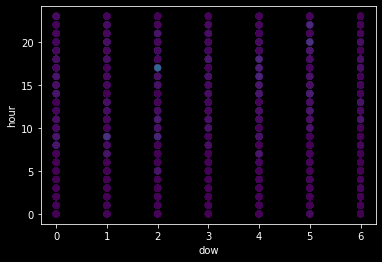

In [37]:
small_df[:20000].scatter(small_df.dow, small_df.hour, c_expr=small_df.avg_volume)

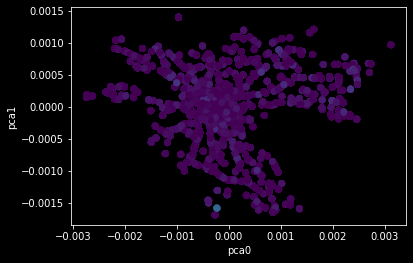

In [38]:
small_df[:20000].scatter(small_df.pca0, small_df.pca1, c_expr=small_df.avg_volume)